# Diabetes prediction with two classes

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
%matplotlib inline

In [101]:
df1 = pd.read_csv("data/demographic.csv")

In [102]:
df2 = pd.read_csv("data/questionnaire.csv")

In [103]:
df3 = pd.read_csv("data/labs.csv")

In [104]:
df4 = pd.read_csv("data/examination.csv")

In [105]:
df = pd.merge(df1, df2, on='SEQN', how='inner')

In [106]:
df = pd.merge(df,df3, on='SEQN', how='inner')

In [107]:
df = pd.merge(df,df4, on='SEQN', how='inner')

In [108]:
df.shape

(9813, 1645)

## Some statistics of the whole dataset

Predict diabetes for people older than 25

In [109]:
df.drop(df.index[df['RIDAGEYR'] < 25], inplace = True)
df.shape

(5095, 1645)

Age is now uniformly distributed

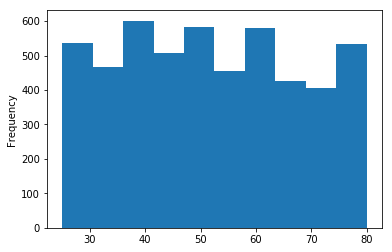

In [110]:
df["RIDAGEYR"].plot.hist()

Gender also looks balanced

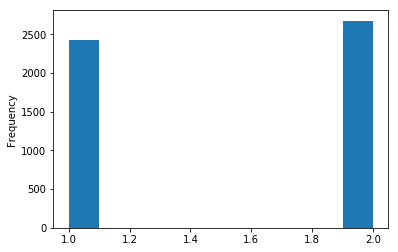

In [111]:
df["RIAGENDR"].plot.hist()

Glycohemoglobin histogram. We see that most of the respondents are in the "green" range of values (4-6%), but there are certainly some who show prediabetes or diabetes condition.

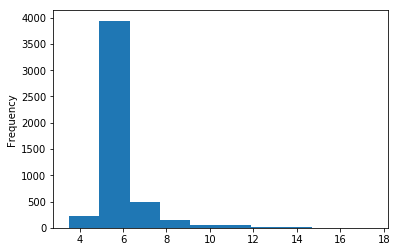

In [112]:
df["LBXGH"].plot.hist()

Unfortunately in the labs.csv there are no fasting glucose levels results even though they shold have been there according to the NHANES website under the code LBXGLU and LBDGLUSI. However two hours glucose tolerance test results are available. We will look at the histogram.

In [113]:
np.sum(df["LBXGH"].notna())

4920

We will exclude people from the analysis that don't have glycohemoglobin results.

In [114]:
df.drop(df.index[df['LBXGH'].isna()], inplace = True)
df.shape

(4920, 1645)

In [115]:
# select multiple columns using loc
diabetes_feat = df.loc[:,['SEQN','RIDAGEYR', 'RIAGENDR', 'DMDEDUC2',
                          'INDFMIN2', 'PAD680', 'PAQ650', 'PAQ655', 
                          'PAD660','PAQ665','PAQ670','PAD675',
                          'DBD900', 'DBD910', 'DPQ030', 'DPQ040', 'WHQ030',
                          'BMXBMI', 'BMXWAIST', 'LBDBMNSI', 'LBXGH']]
diabetes_feat.shape

(4920, 21)

In [116]:
# rename columns properly

diabetes_feat.rename(columns={'SEQN':'id',
                              'RIDAGEYR':'age', 
                              'RIAGENDR':'gender', 
                              'DMDEDUC2':'edu_level',
                              'INDFMIN2':'fam_income',
                              'PAD680':'sedent_activ', 
                              'PAQ650':'vig_activ', 
                              'PAQ655':'days_vig_act',
                              'PAD660':'min_vig_activ',
                              'PAQ665':'moder_activ',
                              'PAQ670':'days_mod_act',
                              'PAD675':'min_mod_activ',
                              'DBD900':'fast_food_freq', 
                              'DBD910':'froz_meal_freq',
                              'DPQ030':'sleep_disorder', 
                              'DPQ040':'little_energy', 
                              'WHQ030':'self_estim_weight', 
                              'BMXBMI':'BMI', 
                              'BMXWAIST':'waist_circum', 
                              'LBDBMNSI':'bld_manganese',
                              'LBXGH':'glycohemoglobin'}, inplace=True)
diabetes_feat.head()

id  age  gender  edu_level  fam_income  sedent_activ  vig_activ  \
0  73557   69       1        3.0         4.0         600.0        2.0   
1  73558   54       1        3.0         7.0         540.0        2.0   
2  73559   72       1        4.0        10.0         300.0        2.0   
4  73561   73       2        5.0        15.0         480.0        2.0   
5  73562   56       1        4.0         9.0         360.0        2.0   

   days_vig_act  min_vig_activ  moder_activ  ...  min_mod_activ  \
0           NaN            NaN          2.0  ...            NaN   
1           NaN            NaN          2.0  ...            NaN   
2           NaN            NaN          1.0  ...          180.0   
4           NaN            NaN          2.0  ...            NaN   
5           NaN            NaN          2.0  ...            NaN   

   fast_food_freq  froz_meal_freq  sleep_disorder  little_energy  \
0             8.0             4.0             0.0            0.0   
1             NaN             2.0             0.0            0.0   
2             0.0             0.0             0.0            0.0   
4             NaN             1.0             0.0            3.0   
5            14.0             0.0             3.0            3.0   

   self_estim_weight   BMI  waist_circum  bld_manganese  glycohemoglobin  
0                3.0  26.7         100.0            NaN             13.9  
1                3.0  28.6         107.6         148.33              9.1  
2                3.0  28.9         109.2         174.17              8.9  
4                2.0  19.7           NaN            NaN              4.9  
5                1.0  41.7         123.1         254.62              5.5  

[5 rows x 21 columns]

Here I will try a binary classification 'no diabetes' - 0, 'diabetes or at risk' - 1

In [117]:
diabetes_feat.loc[diabetes_feat['glycohemoglobin'] < 6.0, 'diabetes'] = 0

diabetes_feat.loc[diabetes_feat['glycohemoglobin'] >= 6.0, 'diabetes'] = 1

A method to assess physical activity of the person (to be improved).

In [118]:
def phys_activity(row):
   # if (row['vig_activ'] == 1 and row['days_vig_act'] >= 2.0) or (row['min_mod_activ'] >=60 and row['min_mod_activ'] >= 2.0):
   if (row['vig_activ'] == 1 and row['days_vig_act'] >= 2.0) or (row['min_mod_activ'] >= 30 and row['min_mod_activ'] >= 3.0):
        return 1
   return 2

diabetes_feat['phys_active'] = diabetes_feat.apply(lambda row: phys_activity(row), axis=1)

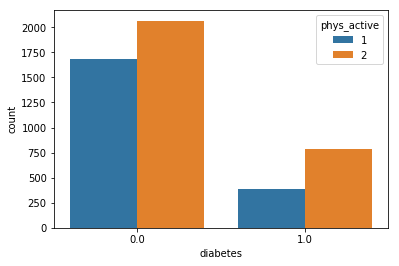

In [119]:
sns.countplot(diabetes_feat['diabetes'], hue=diabetes_feat['phys_active'])

This new variable will not help us predict diabetes. We could simply use 'vig_activity' since almost no one who answered 'yes' has diabetes. So the criteria for a decision tree for instance could be if vig_activ == 1 ==> no diabetes.

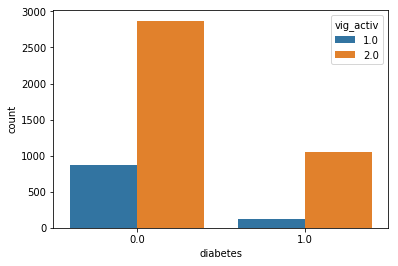

In [120]:
sns.countplot(diabetes_feat['diabetes'], hue=diabetes_feat['vig_activ'])

In [121]:
diabetes_feat.head()

id  age  gender  edu_level  fam_income  sedent_activ  vig_activ  \
0  73557   69       1        3.0         4.0         600.0        2.0   
1  73558   54       1        3.0         7.0         540.0        2.0   
2  73559   72       1        4.0        10.0         300.0        2.0   
4  73561   73       2        5.0        15.0         480.0        2.0   
5  73562   56       1        4.0         9.0         360.0        2.0   

   days_vig_act  min_vig_activ  moder_activ  ...  froz_meal_freq  \
0           NaN            NaN          2.0  ...             4.0   
1           NaN            NaN          2.0  ...             2.0   
2           NaN            NaN          1.0  ...             0.0   
4           NaN            NaN          2.0  ...             1.0   
5           NaN            NaN          2.0  ...             0.0   

   sleep_disorder  little_energy  self_estim_weight   BMI  waist_circum  \
0             0.0            0.0                3.0  26.7         100.0   
1             0.0            0.0                3.0  28.6         107.6   
2             0.0            0.0                3.0  28.9         109.2   
4             0.0            3.0                2.0  19.7           NaN   
5             3.0            3.0                1.0  41.7         123.1   

   bld_manganese  glycohemoglobin  diabetes  phys_active  
0            NaN             13.9       1.0            2  
1         148.33              9.1       1.0            2  
2         174.17              8.9       1.0            1  
4            NaN              4.9       0.0            2  
5         254.62              5.5       0.0            2  

[5 rows x 23 columns]

In [122]:
diabetes_feat.drop(['phys_active', 'days_vig_act','min_vig_activ','moder_activ','days_mod_act','min_mod_activ','glycohemoglobin'], axis=1, inplace=True)

In [123]:
diabetes_feat.head()

id  age  gender  edu_level  fam_income  sedent_activ  vig_activ  \
0  73557   69       1        3.0         4.0         600.0        2.0   
1  73558   54       1        3.0         7.0         540.0        2.0   
2  73559   72       1        4.0        10.0         300.0        2.0   
4  73561   73       2        5.0        15.0         480.0        2.0   
5  73562   56       1        4.0         9.0         360.0        2.0   

   fast_food_freq  froz_meal_freq  sleep_disorder  little_energy  \
0             8.0             4.0             0.0            0.0   
1             NaN             2.0             0.0            0.0   
2             0.0             0.0             0.0            0.0   
4             NaN             1.0             0.0            3.0   
5            14.0             0.0             3.0            3.0   

   self_estim_weight   BMI  waist_circum  bld_manganese  diabetes  
0                3.0  26.7         100.0            NaN       1.0  
1                3.0  28.6         107.6         148.33       1.0  
2                3.0  28.9         109.2         174.17       1.0  
4                2.0  19.7           NaN            NaN       0.0  
5                1.0  41.7         123.1         254.62       0.0

In [124]:
diabetes_feat = diabetes_feat[['age','froz_meal_freq','BMI','waist_circum','diabetes']]
diabetes_feat.head()

age  froz_meal_freq   BMI  waist_circum  diabetes
0   69             4.0  26.7         100.0       1.0
1   54             2.0  28.6         107.6       1.0
2   72             0.0  28.9         109.2       1.0
4   73             1.0  19.7           NaN       0.0
5   56             0.0  41.7         123.1       0.0

In [125]:
# all the above can be replaced by a single command below which deletes a row if any of the values is NaN
diabetes_feat.dropna(axis=0,how='any', inplace=True)

In [126]:
diabetes_feat.shape

(4644, 5)

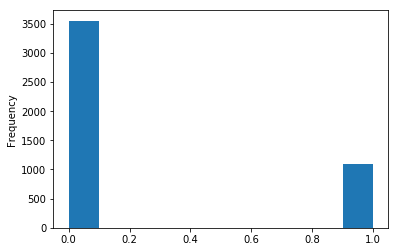

In [128]:
diabetes_feat['diabetes'].plot.hist()

## Value codes
We need to go through each feature column and understand value-codes befor we normalize and standardize the data:  
- **id** - unique identifier (will be excluded from the analysis)  
- **age** - normal age in years  
- **gender** - 1 stands for male, 2 for female  
- **edu_level**   
  
1	Less than 9th grade  
2	9-11th grade (Includes 12th grade with no diploma)  
3	High school graduate/GED or equivalent  
4	Some college or AA degree  
5	College graduate or above  
7	Refused  
9	Don't Know  
  
- annual **fam_income** in dollars  
  
1	0 to 4,999  
2	5,000 to 9,999  
3	10,000 to 14,999	
4	15,000 to 19,999	
5	20,000 to 24,999	
6	25,000 to 34,999	
7	35,000 to 44,999	
8	45,000 to 54,999	
9	55,000 to 64,999	
10	65,000 to 74,999	
12	20,000 and Over    
13	Under 20,000   
14	75,000 to 99,999	
15	100,000 and Over  
77	Refused  
99	Don't know  
*12 and 13 code values should be deleted maybe?*  
  
- **sedent_activ**  
  
Minutes sedentary activity per day.  
Range of values from 0 to 1200  
7777 Refused  
9999 Don't know  
- **fast_food_freq**  
  
Number of meals from fast food/pizza places per week  
Range of values from 0 to 21  
5555 more than 21  
7777  
9999
- **froz_meal_freq**
  
Number of frozen meals or pizzas in the past 30 days  
Range of values between 0 and 180  
7777  
9999  

- **sleep_disorder** (maybe would be better to take the average hours sleeping per night, this info is in the medical condition section)
  
Trouble sleeping or sleeping too much  
0	Not at all  
1	Several days  
2	More than half the days  
3	Nearly every day  
7	Refused  
9	Don't know  
  
- **little_energy** (maybe delete this)

0	Not at all  
1	Several days  
2	More than half the days  
3	Nearly every day  
7	Refused  
9	Don't know  

- **self_estim_weight**
  
How do you consider your weight  
1	Overweight  
2	Underweight  
3	About the right weight  
7	Refused  
9	Don't know  
  
- **BMI**
Body Mass Index is a simple calculation using a person's height and weight. The formula is BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared. A BMI of 25.0 or more is overweight, while the healthy range is 18.5 to 24.9. BMI applies to most adults 18-65 years. (https://www.diabetes.ca/managing-my-diabetes/tools---resources/body-mass-index-(bmi)-calculator)  
  
Range of Values 12.1 to 82.9	
  
- **waist_circum** in cm
Range of values 40.2 to 177.9

- **bld_manganese** (umol/L)
Range of values 31.85 to 999.54

#### 18.09.1991 

I have to delete all 'refused' and 'don't know' answers

In [129]:
diabetes_feat.drop(diabetes_feat.index[(diabetes_feat['froz_meal_freq'] >= 7777) & (diabetes_feat['froz_meal_freq'] <= 9999)], inplace=True)
diabetes_feat.shape

(4644, 5)

In [130]:
print(diabetes_feat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4644 entries, 0 to 9810
Data columns (total 5 columns):
age               4644 non-null int64
froz_meal_freq    4644 non-null float64
BMI               4644 non-null float64
waist_circum      4644 non-null float64
diabetes          4644 non-null float64
dtypes: float64(4), int64(1)
memory usage: 217.7 KB
None


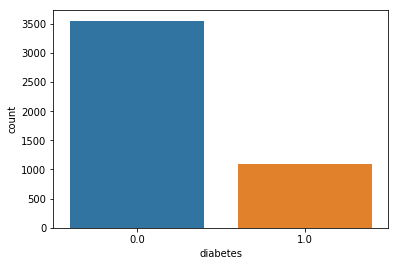

In [131]:
sns.countplot(diabetes_feat['diabetes'],label="Count")

Now I am interested to see how the frequency of diabetes changes with growing BMI. I am expecting that people with the BMI bigger than 25 will have pre-diabetes or diabetes more often.

/Users/elming/anaconda3/envs/dsmlai/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Side-by-Side Histogram')

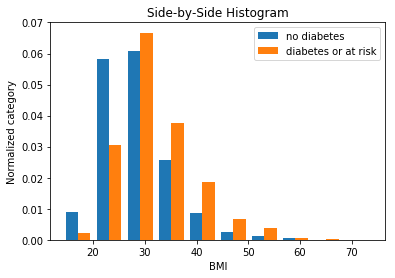

In [132]:
# Code adopted from https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['BMI'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['BMI'])

# Assign colors for each airline and the names

names = ['no diabetes', 'diabetes or at risk']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = 10, normed=True, label=names)

# Plot formatting
plt.legend()
plt.xlabel('BMI')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

Text(0.5, 1.0, 'Stacked Histogram')

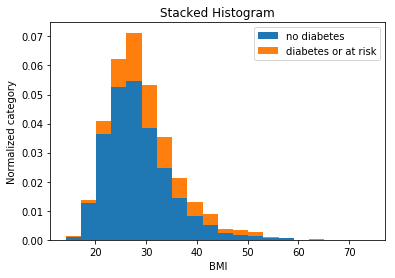

In [133]:
plt.hist([x1, x2], bins = 20, stacked=True,
         normed=True, label=names)
plt.legend()
plt.xlabel('BMI')
plt.ylabel('Normalized category')
plt.title('Stacked Histogram')

As I see on the histograms my expectation was right, most diabetes labeled people have BMI above 25. Now we can perform the same plot based on the waist circumference that was reported to corellate with diabetes.

Text(0.5, 1.0, 'Side-by-Side Histogram')

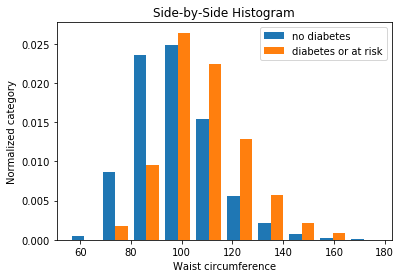

In [134]:
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['waist_circum'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['waist_circum'])


# Assign colors for each airline and the names

names = ['no diabetes', 'diabetes or at risk']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = 10, normed=True, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Waist circumference')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

Same story: the distribution of the healthy people is skewed to the smaller values of the waist_circumference, the distribution of diabetic people or the ones at risk is skewed towards the larger values. Large weight and waist are consequences of bad diet.

Text(0.5, 1.0, 'Side-by-Side Histogram')

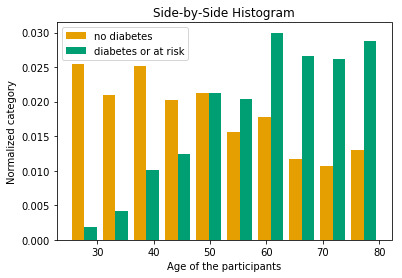

In [135]:
# Make a separate list for each diabetes category
x1 = list(diabetes_feat[diabetes_feat['diabetes'] == 0]['age'])
x2 = list(diabetes_feat[diabetes_feat['diabetes'] == 1]['age'])



# Assign colors for each airline and the names
colors = ['#E69F00', '#009E73']
names = ['no diabetes', 'diabetes or at risk']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = 10, normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Age of the participants')
plt.ylabel('Normalized category')
plt.title('Side-by-Side Histogram')

## Starting with predictions

### Select input features, output and split the data into train and test

In [136]:
diabetes_feat.shape

(4644, 5)

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes_feat.loc[:, diabetes_feat.columns != 'diabetes'], diabetes_feat['diabetes'], stratify=diabetes_feat['diabetes'], test_size=0.25, random_state=66)

In [138]:
len(X_train)

3483

In [139]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3483, 4) (1161, 4) (3483,) (1161,)


In [140]:
np.sum(y_train)

819.0

819 from 3483 people have diabetes, this is almost 1/4. 

In [141]:
np.sum(y_test)

273.0

Let's try to balance the dataset

In [142]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)
print(len(y_ros),len(X_ros))

5328 5328


In [143]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm[0:10,:], y_sm[0:10])

[[ 52.    2.   33.7 115.3]
 [ 45.    0.   19.5  78.6]
 [ 40.    1.   28.1  99.2]
 [ 50.    3.   31.7 118.7]
 [ 40.    1.   32.3 106.5]
 [ 42.    1.   31.1 105.9]
 [ 63.    2.   26.5  94. ]
 [ 32.    4.   26.2  88. ]
 [ 80.    0.   23.7  87. ]
 [ 53.    0.   17.5  69.7]] [1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


In [144]:
print(len(y_sm),len(X_sm))

5328 5328


### Try out KNN Classifier

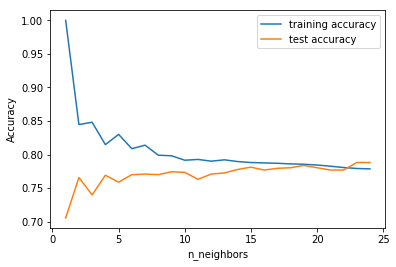

In [145]:
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 25)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

The plot suggests that we should choose n_neighbors=19. Here we are:

In [146]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.78


In [187]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = knn.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[839,  49],
       [202,  71]])

In [278]:
probs = knn.predict_proba(X_test)
probs[:,1]

array([0.        , 0.31578947, 0.31578947, ..., 0.52631579, 0.05263158,
       0.10526316])

AUC: 0.772


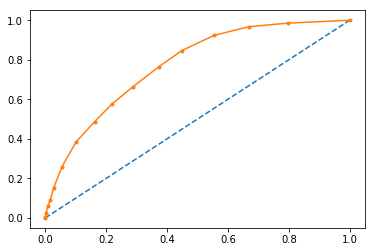

In [279]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# keep probabilities for the positive outcome only
probs = knn.predict_proba(X_test)
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
#pyplot.show()

To do for tomorrow:
1. Go on with other algorithms and look how they perform
2. Look which features help in predicting the most

#### 20.09.2019

## Decision tree

In [175]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=0)
dec_tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dec_tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dec_tree.score(X_test, y_test)))

Accuracy on training set: 0.776
Accuracy on test set: 0.780


In [176]:
print("Feature importances:\n{}".format(dec_tree.feature_importances_))

Feature importances:
[0.62789684 0.         0.01576206 0.35634111]


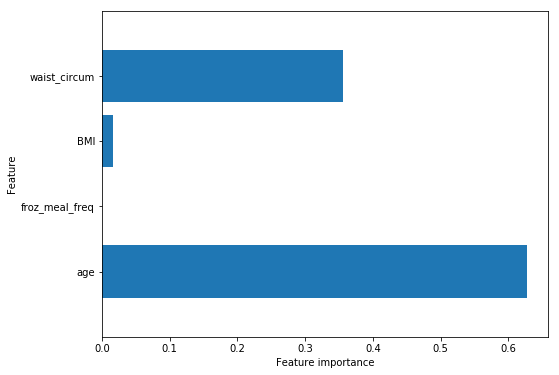

In [177]:
diabetes_features = [x for i,x in enumerate(X_train.columns)]
def plot_feature_importances_diabetes(model):
    plt.figure(figsize=(8,6))
    n_features = 4
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), diabetes_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_diabetes(dec_tree)
plt.savefig('feature_importance')

In [154]:
y_pred = dec_tree.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[852,  36],
       [219,  54]])

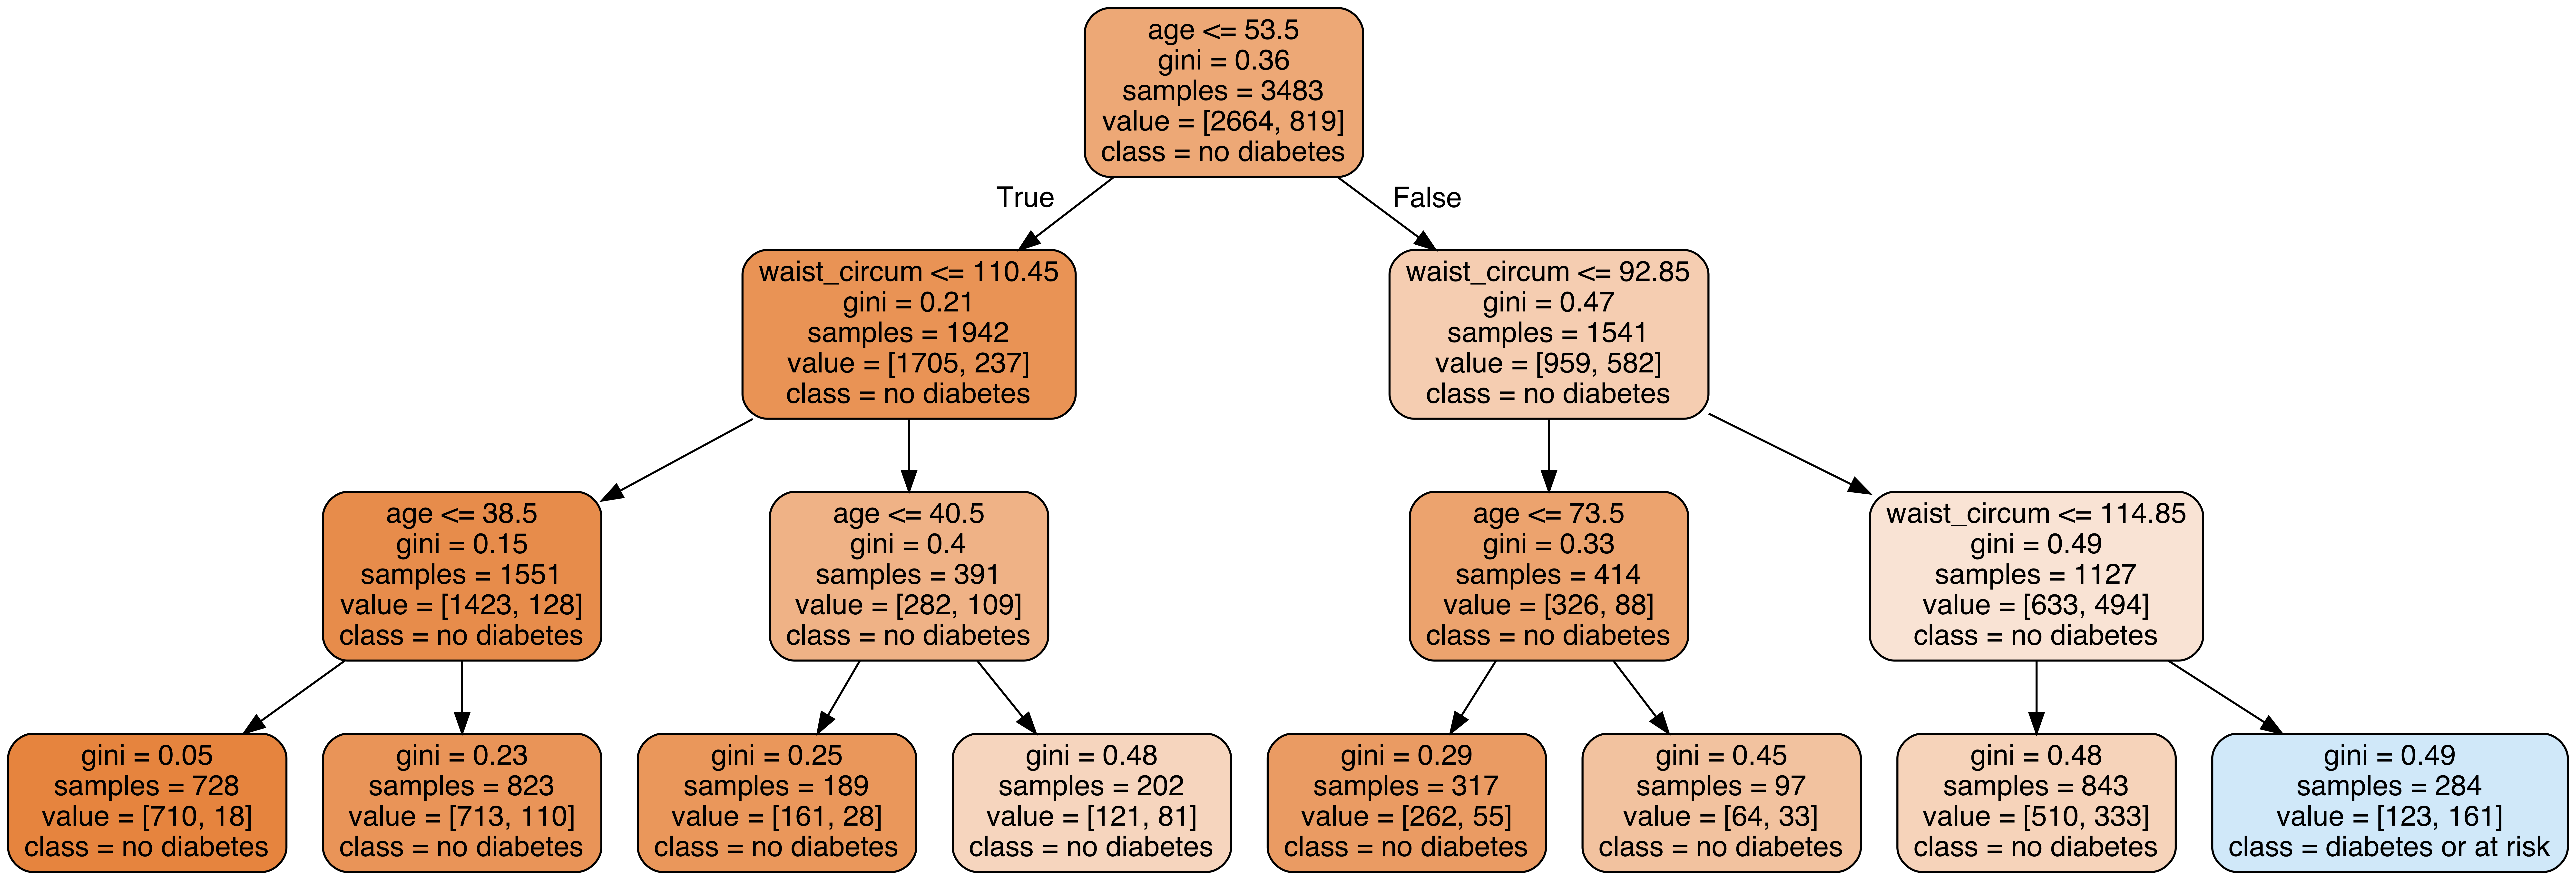

In [155]:
import graphviz
from sklearn.tree import export_graphviz
labels = ['no diabetes', 'diabetes or at risk']

# Export as dot file
export_graphviz(dec_tree, out_file='dec_tree.dot', 
                feature_names = X_train.columns,
                class_names = labels,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'dec_tree.dot', '-o', 'dec_tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'dec_tree.png')

## Random forest

In [182]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=30, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.778
Accuracy on test set: 0.784


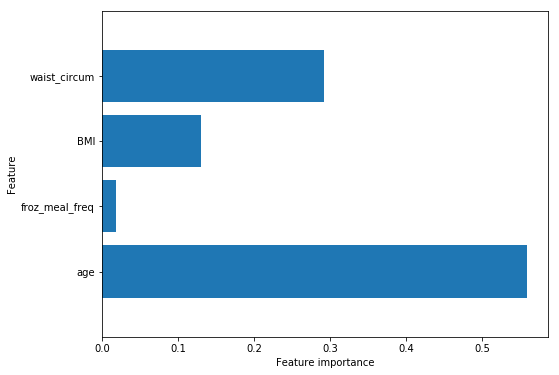

In [183]:
plot_feature_importances_diabetes(rf)

In [184]:
import graphviz
from sklearn.tree import export_graphviz

In [185]:
labels = ['no diabetes', 'diabetes or at risk']
estimator = rf.estimators_[20]

# Export as dot file
export_graphviz(estimator, out_file='tree_binary.dot', 
                feature_names = X_train.columns,
                class_names = labels,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree_binary.dot', '-o', 'tree_binary.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_binary.png')


In [186]:
y_pred = rf.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[869,  19],
       [232,  41]])

AUC: 0.791


Text(0.5, 1.0, 'ROC curve binary classification with RF')

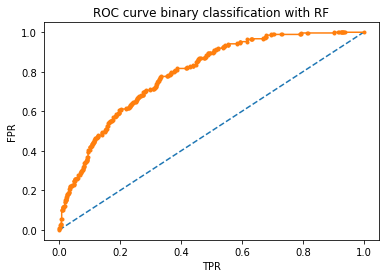

In [190]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# keep probabilities for the positive outcome only
probs = rf.predict_proba(X_test)
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('ROC curve binary classification with RF')
# show the plot
#pyplot.show()

## Support vector machine

In [270]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

/Users/elming/anaconda3/envs/dsmlai/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 0.90
Accuracy on test set: 0.76


Sometimes scaling helps to achieve better results

In [271]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
svc = SVC(C=1, kernel='rbf', gamma=10)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.78
Accuracy on test set: 0.77


In [272]:
y_pred = svc.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[881,   7],
       [260,  13]])

## Deep Learning

In [273]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(100,), max_iter=40)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.776
Accuracy on test set: 0.782


/Users/elming/anaconda3/envs/dsmlai/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [274]:
y_pred = mlp.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[856,  32],
       [221,  52]])

To do:
1. Look at different accuracy score, try ROC curve
2. Work further on Random forests, try less features
3. Try to balance the dataset